## Steps to do for google collab users

In [1]:
# nothing

# Permutation Importance

Let's have a look at **permutation importance**, one of the most effective model-agnostic **global interpretability** technique.

### Algorithm Description: 

After your model is trained, the test set can be used for the permutation importance in the following way

- If the test set has a score/accuracy of (score_test %), the aim is to calculate the drop in score/accuracy (score_test_corrupted %) when one column is randomly shuffled while the other features are untouched. 

- The bigger the drop, the more important this feature is. Conversely, the smaller the drop, the less important.

- Naturally, all columns are permuted at least once to have a feature importance for each feature. 

- Finally, to soften the randomised character of the shuffling, the process is repeated N times for each feature.

- At the end, each feature has a **mean drop** score with its **standard deviation**. 
    - Example: Shuffling feature "height at age 10" produces an accuracy drop of 0.2 (mean) +/- 0.05 (std). 

![permutation_improtance](../images/permutation_importance.png)

Figure 1: Shuffling of the second columns

Source: https://www.kaggle.com/code/dansbecker/permutation-importance



# Purpose of this notebook

- Run your first permutation importance algorithm to get the feature importance of your dataset ! 
- Get some intuition on how to improve your model

Side note: This dataset is a toy dataset easily accessible through scikit learn package and might not represent the complexity of a real dataset (in terms of cleanliness, sample size etc...). However the topic is not too far fetched as it seems, as AXA has more and more activity in **health** !

# Case study: Breast Cancer prediction based on cell caracteristics

Context: One of the first symptom of breast cancer that most women notice is a lump or an area of thicked tissue in their breast. 
A biopsy (sample of tissue taken from the body in order to examine it) is often done in this case. The biomass is then being looked at using a microscope for example and a resulting 2D image of the cells can be generated. 


![breast cell nuclei image](../images/cell_nuclei.png)

[Source](https://www.researchgate.net/publication/311950799_Analysis_of_the_Wisconsin_Breast_Cancer_Dataset_and_Machine_Learning_for_Breast_Cancer_Detection)

**Description**: Magnified images of the cell nuclei used to build this dataset

The following dataset is based on the **features of the cell nuclei** that you see in this image. (It's not computer vision yet 😁)

10 main features like the radius, the area, the concavity of those cell nuclei are derived from the image. You can find those features in 3 versions with different prefix (mean, error, worst). 
For example the radius feature can be found as the:
- mean_radius -> the mean radius of the N nuclei displayed in the slice
- error_radius -> standard error of the mean radius
- worst_radius -> mean of the largest 3 nuclei displayed in the slice

## Import libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split

## Load breast cancer dataset

In [4]:
breast_cancer = datasets.load_breast_cancer()

In [5]:
# description of the dataset
print(breast_cancer.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

## Train a ML model on this dataset to predict breast cancer

### Split dataset
The data set of N=569 is split into a training set (70%) and test set (30%)

In [6]:
# Train set 70%, Test set 30 %
test_size = 0.3 
X, y = breast_cancer.data, breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=test_size, random_state=2)

### Training
The model selected (arbitrarily) is the random forest

In [7]:
from sklearn import ensemble

In [8]:
model = ensemble.RandomForestClassifier(max_depth=5, random_state=2)
model = model.fit(X_train, y_train)
pred = model.predict(X_test)

In [9]:
# prediction on test set 
accuracy = round(model.score(X_test, y_test), 2)
print(f"Accuracy Tree model is of {accuracy}, N_test={len(y_test)}")

Accuracy Tree model is of 0.96, N_test=171


## Comments 

The accuracy on the test set seems to be very good (96%). We are satisfied with the model performance.

Now...

![image](../images/to_spam.png)

## Run the permutation importance algorithm 

Now that the trained ML model is performant, we can make some predictions on the test set while **permutating** the features. 

The more the accuracy drop for a feature permuted, the more important this feature is ! 
 
As usual, to avoid overfitting issues, the permutation importance algorithm is performed on the **test set** (N=171). 

In [13]:
from sklearn.inspection import permutation_importance

In [14]:
%%time 
result = permutation_importance(
    model, 
    X_test, 
    y_test, 
    n_repeats=30, 
    random_state=2
)
# The score is calculated using the defalut scorer of the estimator. In this case it's the mean accuracy.
# n_repeats is the number of time each feature is shuffled

CPU times: user 8.08 s, sys: 123 ms, total: 8.21 s
Wall time: 8.24 s


### Display feature importance distribution

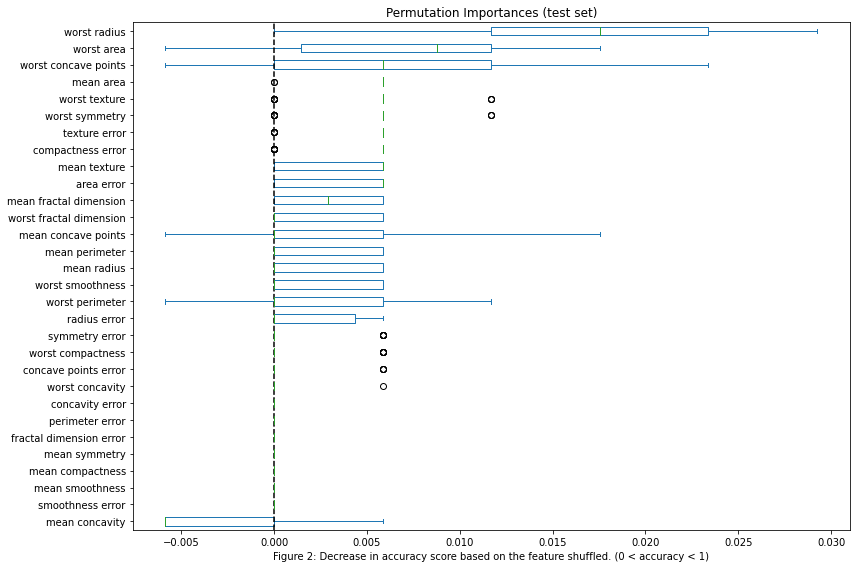

In [15]:
sorted_importances_idx = result.importances_mean.argsort()
columns = [breast_cancer.feature_names[i] for i in sorted_importances_idx]

importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=columns,
)
importances.plot.box(vert=False, whis=10, figsize=(12, 8))
plt.title("Permutation Importances (test set)")
plt.axvline(x=0, color="k", linestyle="--")
plt.xlabel("Figure 2: Decrease in accuracy score based on the feature shuffled. (0 < accuracy < 1)")
plt.tight_layout()

### All feature importances sorted from best to worst (according to mean drop of accuracy)

In [17]:
for i in result.importances_mean.argsort()[::-1]:
    print(f"{breast_cancer.feature_names[i]:<8} "
          f"{result.importances_mean[i]:.3f} "
          f" +/- {result.importances_std[i]:.3f}")

worst radius 0.018  +/- 0.008
worst area 0.007  +/- 0.007
worst concave points 0.006  +/- 0.007
mean area 0.005  +/- 0.001
worst texture 0.005  +/- 0.003
worst symmetry 0.005  +/- 0.003
texture error 0.005  +/- 0.002
compactness error 0.004  +/- 0.002
mean texture 0.004  +/- 0.003
area error 0.004  +/- 0.003
mean fractal dimension 0.003  +/- 0.003
worst fractal dimension 0.003  +/- 0.003
mean concave points 0.002  +/- 0.006
mean perimeter 0.002  +/- 0.003
mean radius 0.002  +/- 0.003
worst smoothness 0.002  +/- 0.003
worst perimeter 0.002  +/- 0.005
radius error 0.002  +/- 0.003
symmetry error 0.001  +/- 0.002
worst compactness 0.001  +/- 0.002
concave points error 0.001  +/- 0.002
worst concavity 0.000  +/- 0.001
concavity error 0.000  +/- 0.000
perimeter error 0.000  +/- 0.000
fractal dimension error 0.000  +/- 0.000
mean symmetry 0.000  +/- 0.000
mean compactness 0.000  +/- 0.000
mean smoothness 0.000  +/- 0.000
smoothness error 0.000  +/- 0.000
mean concavity -0.003  +/- 0.003


Some observations: 
- By shuffling the feature "worst radius" n_repeats times, the mean drop in accuracy is 0.017 (1.7 %) with a standard deviation of 0.008 (0.8%). According to the list, it **seems** to be the most important feature of all.
- By shuffling the feature "mean concativity" n_repeats times, the mean drop in accuracy is actually -0.003 (-0.3%) with a standard deviation of 0.003 (0.3%). Surprisingly there is actually a gain in accuracy when shuffling this feature. it **seems** that this feature does not contribute postively to the accuracy of the model.
- Other features at the bottom of the list such as "smoothness error", "mean smoothness", "mean compactness" etc with a mean drop of 0% and a standard deviation of 0% also suggest that those features don't matter in the eyes of the model.

### Filter out features that have a mean drop that is too volatile 

Often times, we trust more the features whose mean drop in accuracy are at laest greater than 2 times their standard deviation. Those are the features that consistently see a positive drop in accuracy regardless of the shuffling random state.

In [19]:
for i in result.importances_mean.argsort()[::-1]:
    if result.importances_mean[i] - 2 * result.importances_std[i] > 0:
        print(f"{breast_cancer.feature_names[i]:<8} "
              f"{result.importances_mean[i]:.3f} "
              f" +/- {result.importances_std[i]:.3f}")

worst radius 0.018  +/- 0.008
mean area 0.005  +/- 0.001
texture error 0.005  +/- 0.002


## Human interpretation of the result - and Challenge with expert

As a data scientist, I have no background in cancerous cell analysis. 
But from the following observations derived from a global interpretation of the model with permutation importance: 
- The worst prefix is seen for the 5 out of the 6 top important features (as shown in figure 1)
- The top 2 important features are worst radius and worst area  
- Some features have a 0 % point drop and even positive gain from shuffling.

We could make following assumptions:

**Assumption 1**

- that cancerous cell nuclei are larger than healthy ones. In each slice of cells represented in the images such as image 1, cancerous cells might not represent the majority of the cell displayed, that's why the feature with the worst prefix might make a lot of sense.

**Assumption 2**
- Some features could be removed because they negatively impact our model or have no positive contribution. In a 30 feature dataset it might not be really important but for a larger number of features, discarding a certain amount is always helpful to reduce memory issues and improve performances. Some minor features can bring bias, be harmful to the model.

**Assumption 3**
- Drop in accuracy for all features is rather low. Does it mean the feature are correlated ?

Next step: I would contact an expert in this domain and present my model and my take away from the interpretability inspection. 

- If the expert **confirms the assumption** that I made, **I can have more confidence in my model while also gaining his/her trust.**

- If the expert **does not validate** those assumptions, **my model could be accurate but for the different reasons** Therefore, I need to take a step back to re-analyze each part of the model (from feature selection, engineering to the model training).** 

**This is exactly the type of behaviour that we should adopt between data scientists and suject expert matters / stakeolders / agents at AXA !** 




## Conclusion

By applying the permutation importance method, 
- you gain insights on the data set as it encourages you to understand each feature
- it gives you an understanding of the feature importance of the model which you can test against your own understanding of the problem. And challenge it with a specialist.